In [1]:
from GeoGuesserSystem import *

In [2]:
BR = system_loader()

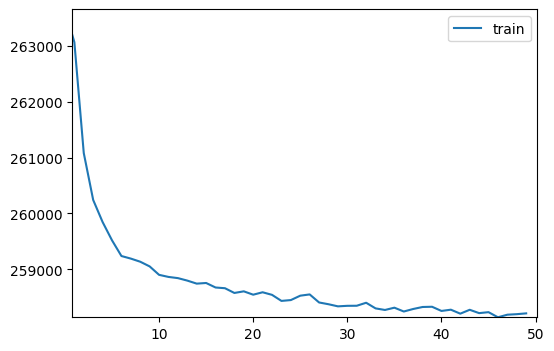

In [3]:
BR.train(50)

In [ ]:
save_system(BR)

In [ ]:
BR.generate_test_main()

In [ ]:
loss_prop, gradient_analysis = BR.asses_photos(data=next(iter(BR.test_dataloader)))

In [ ]:
gradient_analysis[-7]

In [ ]:
BR.metrics_and_plots()